In [ ]:
pip install geopandas

In [ ]:
import os
import fiona
import numpy as np
import pprint
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import geopandas as gpd
import pandas as pd
import json
import pyproj
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely import wkt
from shapely.ops import transform
import warnings
import seaborn as sns
import copy
warnings.filterwarnings("ignore") 

In [ ]:
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt

df=pd.read_csv("budynki_multi.csv", sep='\t') 
results = []
for index, row in df.iterrows():
  results.append(wkt.loads(row["wkt_geom"]))

### Odwzorowanie warstwy budynków z EPSG:2180 do EPSG:4326

In [ ]:
project = pyproj.Transformer.from_proj(
    pyproj.Proj(init="epsg:2180"),
    pyproj.Proj(init="epsg:4326")) 

new_results = []
for multipolygon in results:
  new_polygons = []
  for polygon in multipolygon:
    new_coords = []
    coords = np.array(polygon.exterior.coords)
    for [x, y] in coords:
      point = Point(x, y)
      new_point = list(transform(project.transform, point).coords)
      new_coords.append(new_point[0])
    new_polygon = Polygon(new_coords)
    new_polygons.append(new_polygon)
  new_multipolygon = MultiPolygon(new_polygons)
  new_results.append(new_multipolygon)
print(f"Coords of first polygon in EPSG:2180:\n{np.array(results[0][0].exterior.coords)}\n")
print(f"Coords of first polygon in EPSG:4326:\n{np.array(new_results[0][0].exterior.coords)}")

Coords of first polygon in EPSG:2180:
[[204435.34 628091.05]
 [204433.45 628080.8 ]
 [204431.87 628081.06]
 [204431.25 628077.74]
 [204432.83 628077.49]
 [204432.55 628076.02]
 [204426.76 628076.94]
 [204427.02 628078.55]
 [204419.62 628079.6 ]
 [204419.07 628085.36]
 [204419.05 628085.47]
 [204418.14 628092.17]
 [204417.36 628097.92]
 [204427.6  628099.21]
 [204427.84 628097.55]
 [204433.7  628091.34]
 [204435.34 628091.05]]

Coords of first polygon in EPSG:4326:
[[14.54838523 53.43477901]
 [14.54836648 53.43468607]
 [14.54834252 53.43468751]
 [14.54833633 53.4346574 ]
 [14.54836028 53.43465605]
 [14.54835746 53.43464271]
 [14.54826968 53.43464772]
 [14.54827207 53.43466229]
 [14.54816    53.43466756]
 [14.54814634 53.43471888]
 [14.54814594 53.43471986]
 [14.54812599 53.43477941]
 [14.54810888 53.43483052]
 [14.54826139 53.43484782]
 [14.54826655 53.43483308]
 [14.54836034 53.43478069]
 [14.54838523 53.43477901]]


### Obliczanie sumarycznej powierzchni budynków po klasach

In [ ]:
build_types = df.typ_budynku.unique()
build_types_area = pd.DataFrame(data=np.c_[build_types, np.zeros(len(build_types))], columns=["build types", "area"])
for idx, build_type in enumerate(build_types):
  areas = [wkt.loads(row["wkt_geom"])[0].area for index, row in df[df.typ_budynku == build_type].iterrows()]
  build_types_area["area"][idx] = np.array(areas).sum()
build_types_area

,build types,area
0,biura i usługi,6015.66
1,szpital,1951.16
2,przemysłowe,3859.4
3,hotele i schroniska,331.767
4,mieszkalne,115519


### Wizualizacja mapy wektorowej

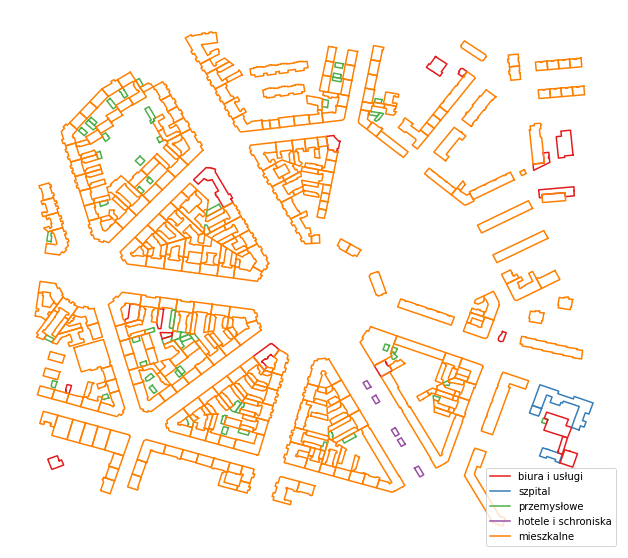

In [ ]:
palette = sns.color_palette("Set1", len(build_types))
build_types_colors = dict(zip(build_types, list(palette)))
fig, ax = plt.subplots(figsize=(11, 10))
for build_type, multipolygon in zip(df.typ_budynku, results):
  color = build_types_colors[build_type]
  ax.plot(*multipolygon[0].exterior.xy, label=build_type, color=color)
ax.set_axis_off()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()

### Wygenerowanie łosowych punktów i sprawdzenie przynależności do poligonów.

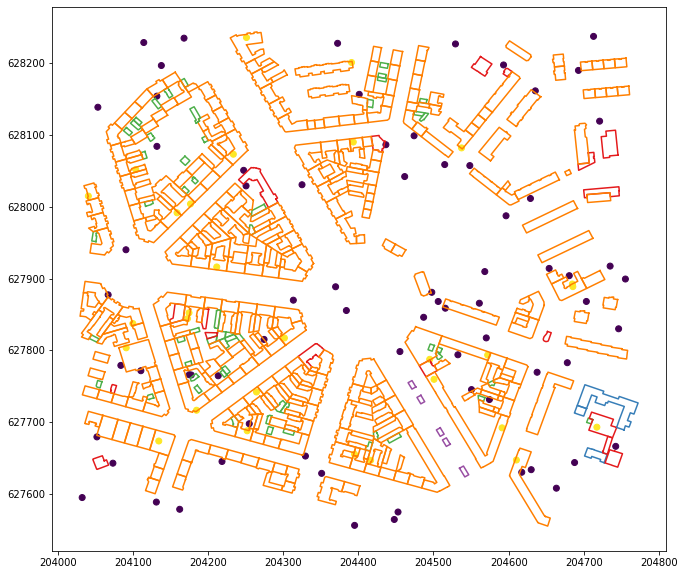

,x,y,is in
0,204630.041972,627633.966698,False
1,204755.391839,627899.360808,False
2,204680.679435,627904.033344,False
3,204184.685355,627716.704487,True
4,204213.537932,627764.668808,False
...,...,...,...
95,204486.895237,627846.105334,False
96,204685.448599,627888.796406,True
97,204369.741831,627888.590238,False
98,204663.537940,627608.181807,False


In [ ]:
n = 100
coords = np.array(results[0][0].exterior.coords).T
x_min = np.min(coords[::2])
y_min = np.min(coords[1::2])
x_max = np.max(coords[::2])
y_max = np.max(coords[1::2])
for multipolygon in results[1:]:
  coords = np.array(multipolygon[0].exterior.coords).T
  x_min = np.min([np.min(coords[::2]), x_min])
  y_min = np.min([np.min(coords[1::2]), y_min])
  x_max = np.max([np.max(coords[::2]), x_max])
  y_max = np.max([np.max(coords[1::2]), y_max])

x = np.random.uniform(x_min, x_max, n)
y = np.random.uniform(y_min, y_max, n)

is_in = np.zeros(n)
for i in range(n):
  is_in[i] = np.sum([multipolygon[0].contains(Point(x[i], y[i])) for multipolygon in results] * 1)
coords = np.array([x, y]).T
is_in_df = pd.DataFrame(np.c_[x, y, is_in], columns=["x", "y", "is in"])
is_in_df["is in"] = is_in_df["is in"].astype("bool")


palette = sns.color_palette("Set1", len(build_types))
build_types_colors = dict(zip(build_types, list(palette)))
fig, ax = plt.subplots(figsize=(11, 10))
for build_type, multipolygon in zip(df.typ_budynku, results):
  color = build_types_colors[build_type]
  ax.plot(*multipolygon[0].exterior.xy, label=build_type, color=color)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.scatter(x, y, c=is_in_df["is in"])
plt.show()

is_in_df